### 🕵️‍♂️ Check‑worthy Claim Detection

The **Check‑worthy Claim Detection** tool flags sentences that deserve human fact‑checking—statements that could misinform the public or have real‑world impact. It helps analysts sift massive news streams and focus on the most important claims.

| Key feature | Description |
|-------------|-------------|
| **Label**   | `1` = check‑worthy, `0` = not |
| **Score**   | Confidence from 0 to 1 |
| **Granularity** | Whole text **and** per‑segment spans |
| **Languages**  | English, Spanish, Italian |
| **Model**   | Transformer (BERT/Roberta family) with multi‑task fine‑tuning on factuality signals |




In [ ]:
# ─────────────────────────────────────────────────────────────────────────────
# 1 ▸ Dependencies  (Polars, Matplotlib, Trino client)
# ─────────────────────────────────────────────────────────────────────────────
%pip install -qU "trino[sqlalchemy]==0.332.0" "polars>=0.19" matplotlib


In [ ]:

import os, re, json, datetime as dt
from pathlib import Path
import polars as pl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from trino.dbapi import connect


In [ ]:

# ─────────────────────────────────────────────────────────────────────────────
# JSON helpers
# ─────────────────────────────────────────────────────────────────────────────
def _json_default(v):
    if isinstance(v, (dt.datetime, dt.date)):
        return v.isoformat()
    return repr(v)

def save_dict(d: dict, path: Path):  path.write_text(json.dumps(d, default=_json_default))
def load_dict(path: Path) -> dict:   return json.loads(path.read_text())

def df_from_data_d(data_d: dict) -> pl.DataFrame:
    df = pl.DataFrame(data_d)
    if df["publish_date"].dtype == pl.Utf8:
        df = df.with_columns(
            pl.col("publish_date")
              .str.to_datetime(strict=False)
              .dt.date()
              .alias("publish_date")
        )
    return df

# ─────────────────────────────────────────────────────────────────────────────
# Host/port parser
# ─────────────────────────────────────────────────────────────────────────────
def _parse_host_port(host: str, port: str, default_port: int = 8080):
    host = (host or "").strip();  port = (port or "").strip()
    host = re.sub(r"^(?:https?|tcp)://", "", host, flags=re.I)
    if ":" in host and not port:
        host, port = host.split(":", 1)
    try:
        port_int = int(re.sub(r"\D", "", port))
    except ValueError:
        port_int = default_port
    if not (1 <= port_int <= 65_535):
        port_int = default_port
    return host or "localhost", port_int


In [ ]:

# ─────────────────────────────────────────────────────────────────────────────
# 2 ▸ Parameters
# ─────────────────────────────────────────────────────────────────────────────
LIMIT       = None
START_DATE  = "2025-04-25"
END_DATE    = "2025-06-29"
JSON_PATH   = Path("checkworthy_claim_detection_plot.json")


In [ ]:

# ─────────────────────────────────────────────────────────────────────────────
# 3 ▸ Connect to Trino
# ─────────────────────────────────────────────────────────────────────────────
TRINO_HOST, TRINO_PORT = _parse_host_port(os.getenv("TRINO_HOST"), os.getenv("TRINO_PORT"))
TRINO_USER    = os.getenv("TRINO_USER", "jupyter")
TRINO_CATALOG = os.getenv("TRINO_CATALOG", "iceberg")
print(f"🔌 Connecting to Trino at {TRINO_HOST}:{TRINO_PORT}, catalog='{TRINO_CATALOG}'")

conn = connect(host=TRINO_HOST, port=TRINO_PORT, user=TRINO_USER, catalog=TRINO_CATALOG)
cur  = conn.cursor()


🔌 Connecting to Trino at trino:8080, catalog='iceberg'


In [ ]:

# ─────────────────────────────────────────────────────────────────────────────
# 4 ▸ Run query
# ─────────────────────────────────────────────────────────────────────────────
query = """
SELECT
    cn.id           AS id_collected_news,
    cn.publish_date,
    cn.title        AS title_collected_news,
    cn.text,
    tccd.title      AS title_checkworthy_claim_detection,   -- ROW(score, label)
    tccd.body       AS body_checkworthy_claim_detection,    -- ROW(score, label)
    tccd.created_at AS created_at_tccd
FROM news.collected_news AS cn
JOIN tools.text_checkworthy_claim_detection AS tccd
  ON cn.id = tccd.content_id
"""
if LIMIT is not None:
    query += f"\nLIMIT {LIMIT}"

print("⏳ Executing query…")
try:
    cur.execute(query)
    rows    = cur.fetchall()
    columns = [c[0] for c in cur.description]
finally:
    cur.close();  conn.close()

if not rows:
    raise ValueError("No data found.")
print(f"✅ Retrieved {len(rows):,} rows")


⏳ Executing query…
✅ Retrieved 5,810 rows


In [ ]:

# ─────────────────────────────────────────────────────────────────────────────
# 5 ▸ Build Polars DataFrame  (robust to mixed types)
# ─────────────────────────────────────────────────────────────────────────────
assert all(len(r) == len(columns) for r in rows), "Row/column mismatch"

data_dict = {col: [row[i] for row in rows] for i, col in enumerate(columns)}
for col in ("title_checkworthy_claim_detection", "body_checkworthy_claim_detection"):
    data_dict[col] = pl.Series(col, data_dict[col], dtype=pl.Object)

df = pl.DataFrame(data_dict, strict=False)


In [ ]:

# ─────────────────────────────────────────────────────────────────────────────
# 6 ▸ Parse ROW(...) → score/label
# ─────────────────────────────────────────────────────────────────────────────
def _parse_row(v):
    if v is None: return (None, None)
    if isinstance(v, dict): return (v.get("score"), v.get("label"))
    if isinstance(v, tuple) and len(v) == 2: return v
    m = re.match(r"\(?\s*(?:score\s*:\s*)?([0-9.+\-eE]+)\s*,\s*(?:label\s*:\s*)?([0-9]+)\s*\)?", str(v))
    return (float(m.group(1)), int(m.group(2))) if m else (None, None)

df = df.with_columns([
    pl.Series("score_title", [p[0] for p in map(_parse_row, df["title_checkworthy_claim_detection"])]),
    pl.Series("label_title", [p[1] for p in map(_parse_row, df["title_checkworthy_claim_detection"])]),
    pl.Series("score_body" , [p[0] for p in map(_parse_row, df["body_checkworthy_claim_detection" ])]),
    pl.Series("label_body" , [p[1] for p in map(_parse_row, df["body_checkworthy_claim_detection" ])]),
])


In [ ]:

# ─────────────────────────────────────────────────────────────────────────────
# 7 ▸ Date cleaning + range filter (handles any ISO‑8601 string)
# ─────────────────────────────────────────────────────────────────────────────
df = df.with_columns(
        pl.col("publish_date")
          .cast(pl.Utf8)               # guarantee string
          .str.to_datetime(strict=False)
          .dt.date()
          .alias("publish_date")
     )\
     .filter(pl.col("publish_date").is_not_null())

if START_DATE:
    df = df.filter(pl.col("publish_date") >= dt.date.fromisoformat(START_DATE))
if END_DATE:
    df = df.filter(pl.col("publish_date") <= dt.date.fromisoformat(END_DATE))
print(f"After date filter: {df.height:,} rows")


After date filter: 5,155 rows


In [ ]:

# ─────────────────────────────────────────────────────────────────────────────
# 8 ▸ Aggregate daily positives
# ─────────────────────────────────────────────────────────────────────────────
daily = (df.group_by("publish_date")
           .agg([
               (pl.col("label_body")  == 1).sum().alias("body_positive"),
               (pl.col("label_title") == 1).sum().alias("title_positive")
           ])
           .sort("publish_date"))
print(daily.head())

# ─────────────────────────────────────────────────────────────────────────────
# 9 ▸ Save plot metadata ➜ JSON
# ─────────────────────────────────────────────────────────────────────────────
plot_meta = {
    "data"      : daily.to_dict(as_series=False),
    "title"     : "Daily count of positive body and title detected",
    "labels"    : ["Body positive (label = 1)", "Title positive (label = 1)"],
    "color_map" : {"body_positive": "seagreen", "title_positive": "lightblue"},
    "chart_type": "grouped_bar",
    "platform"  : "News",
}
save_dict(plot_meta, JSON_PATH)
print(f"💾 Saved JSON → {JSON_PATH.resolve()}")


shape: (5, 3)
┌──────────────┬───────────────┬────────────────┐
│ publish_date ┆ body_positive ┆ title_positive │
│ ---          ┆ ---           ┆ ---            │
│ date         ┆ u32           ┆ u32            │
╞══════════════╪═══════════════╪════════════════╡
│ 2025-04-26   ┆ 0             ┆ 0              │
│ 2025-04-28   ┆ 0             ┆ 0              │
│ 2025-04-29   ┆ 2             ┆ 6              │
│ 2025-04-30   ┆ 11            ┆ 96             │
│ 2025-05-01   ┆ 6             ┆ 45             │
└──────────────┴───────────────┴────────────────┘
💾 Saved JSON → /home/kadkhoda/checkworthy_claim_detection_plot.json


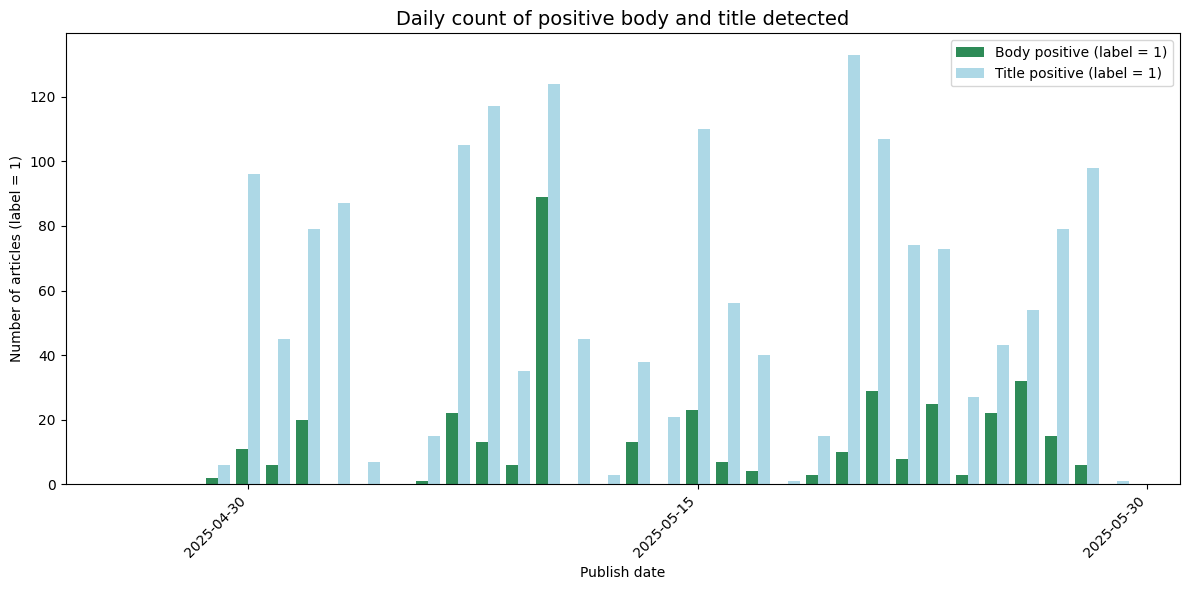

In [ ]:

# ─────────────────────────────────────────────────────────────────────────────
# 10 ▸ Reload JSON & plot
# ─────────────────────────────────────────────────────────────────────────────
meta = load_dict(JSON_PATH)
df_plot = df_from_data_d(meta["data"])

dates   = df_plot["publish_date"].to_list()
body    = df_plot["body_positive"].to_list()
title   = df_plot["title_positive"].to_list()
x_dates = mdates.date2num([dt.datetime(d.year, d.month, d.day) for d in dates])

plt.rcParams.update({"axes.grid": False, "figure.facecolor": "white", "axes.facecolor": "white"})
fig, ax = plt.subplots(figsize=(12, 6))

bar_w = 0.4
ax.bar(x_dates - bar_w/2, body,  width=bar_w, color=meta["color_map"]["body_positive"],  label=meta["labels"][0])
ax.bar(x_dates + bar_w/2, title, width=bar_w, color=meta["color_map"]["title_positive"], label=meta["labels"][1])

ax.set_xlabel("Publish date")
ax.set_ylabel("Number of articles (label = 1)")
ax.set_title(meta["title"], fontsize=14)

ax.xaxis.set_major_locator(mdates.DayLocator(interval=15))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
plt.setp(ax.get_xticklabels(), rotation=45, ha="right")

ax.legend()
plt.tight_layout()
plt.show()
